In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker 

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26bcffb3f10>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'id': 1,
 'prcp': 0.08}

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
qry = session.query(func.max(measurement.date).label("last_date"))
res = qry.one()
last_date = res.last_date
last_date

'2017-08-23'

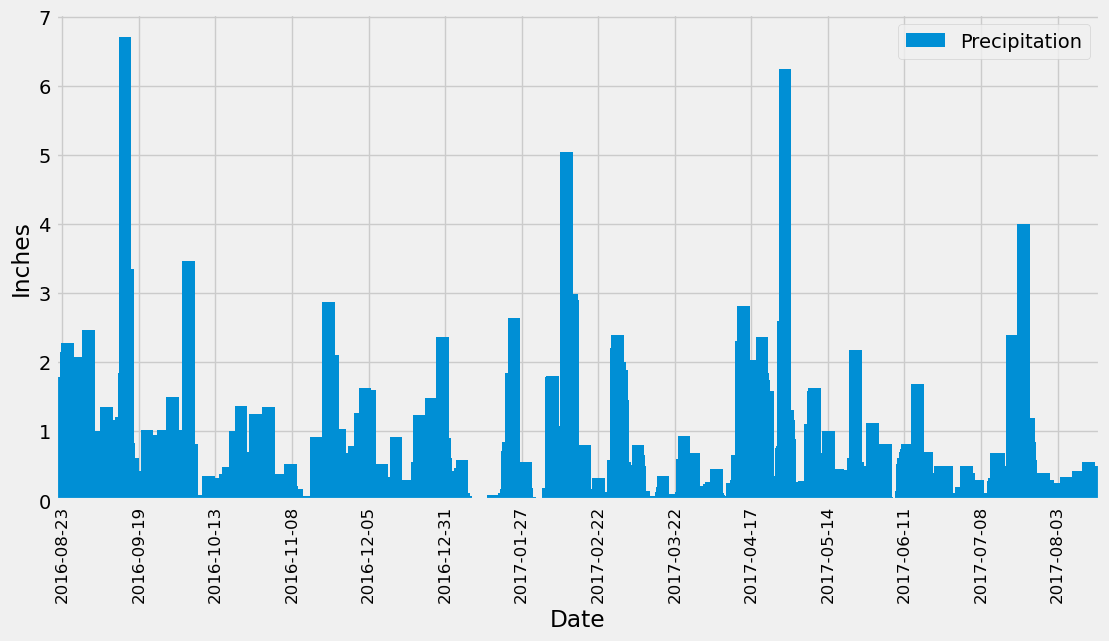

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = datetime.strptime(last_date, '%Y-%m-%d')
#start_date = last_date - relativedelta(years=1)
start_date = last_date - relativedelta(days=366)   #Not sure why but the notes assume that the start date is 1 year and 1 day before the end date.

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date,measurement.prcp).\
    filter(measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(results)
prcp_df = prcp_df.dropna()
prcp_df = prcp_df.rename(columns={'date': 'Date', 'prcp': 'Precipitation'})

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by='Date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(kind="bar",x="Date",y="Precipitation",width=25,grid=True,figsize=(12,6))
tick_spacing = 150
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.legend(loc='upper right')
plt.xticks(fontsize=12)
plt.ylabel("Inches")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats_desc = prcp_df["Precipitation"].describe().round(3)
print(stats_desc)

print("\n----------------------\n")

stats_agg = prcp_df.agg({"Precipitation":["count","min","max","median","mean","std"]}).round(3)
print(stats_agg)

count    2021.000
mean        0.177
std         0.461
min         0.000
25%         0.000
50%         0.020
75%         0.130
max         6.700
Name: Precipitation, dtype: float64

----------------------

        Precipitation
count        2021.000
min             0.000
max             6.700
median          0.020
mean            0.177
std             0.461


# Exploratory Station Analysis

In [13]:
# Find the content of the first row for information purposes
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1700d69ed10>,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [14]:
# Design a query to calculate the total number of stations in the dataset
num = session.query(station.station).count()
print(f"Total number of stations = {num}")

Total number of stations = 9


In [20]:
# List the codes and names of the stations for information purposes. 
names = session.query(station.station,station.name).all()
names_df = pd.DataFrame(names)
names_df.head(10)

,station,name
0,USC00519397,"WAIKIKI 717.2, HI US"
1,USC00513117,"KANEOHE 838.1, HI US"
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,USC00517948,"PEARL CITY, HI US"
4,USC00518838,"UPPER WAHIAWA 874.3, HI US"
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
6,USC00519281,"WAIHEE 837.5, HI US"
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
8,USC00516128,"MANOA LYON ARBO 785.2, HI US"


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

qry = session.query(measurement.station,func.count(measurement.prcp)).\
        group_by(measurement.station).order_by(desc(func.count(measurement.prcp))).all()

for x in range(0,len(qry)-1):
    print(f"Station: {qry[x][0]}, Num of readings: {qry[x][1]}")


Station: USC00519281, Num of readings: 2772
Station: USC00513117, Num of readings: 2696
Station: USC00519397, Num of readings: 2685
Station: USC00519523, Num of readings: 2572
Station: USC00516128, Num of readings: 2484
Station: USC00514830, Num of readings: 1937
Station: USC00511918, Num of readings: 1932
Station: USC00517948, Num of readings: 683


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == qry[0][0]).all()
min_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == qry[0][0]).all()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == qry[0][0]).all()

print(f"Station: {qry[0][0]} \n  Max Temp: {max_temp[0][0]} \n  Min Temp: {min_temp[0][0]} \n  Av. Temp: {round(avg_temp[0][0],1)}")

Station: USC00519281 
  Max Temp: 85.0 
  Min Temp: 54.0 
  Av. Temp: 71.7


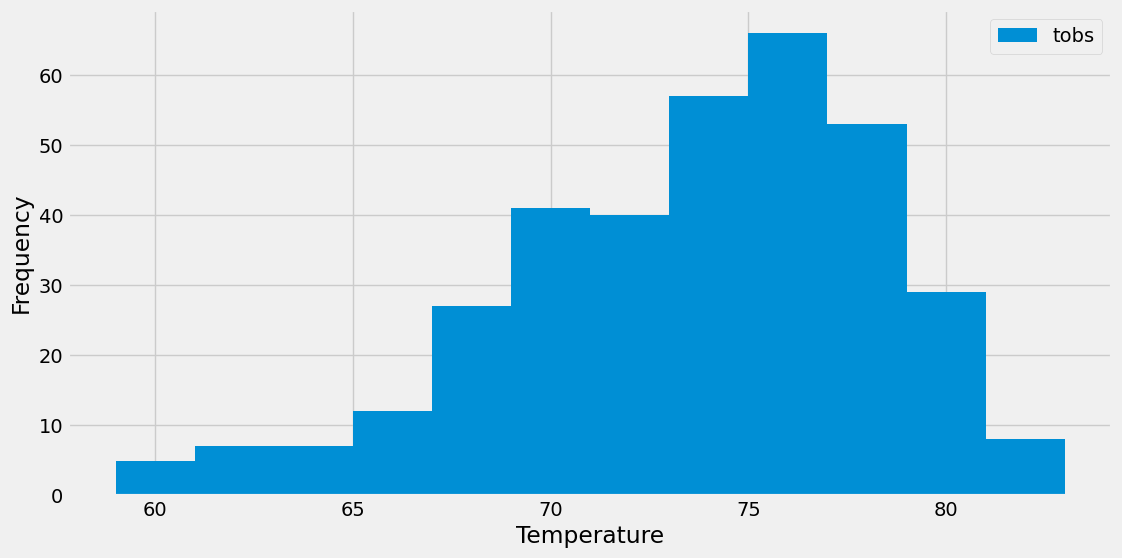

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(measurement.date,measurement.tobs).\
            filter((measurement.station == qry[0][0]) & \
                   (measurement.date >= start_date)).all()

temp_df = pd.DataFrame(results)
temp_df = temp_df.dropna()
ax = temp_df.plot(kind="hist",x="date",y="tobs",bins=12,figsize=(12,6))
plt.xlabel("Temperature")
plt.show()

# Close Session

In [24]:
# Close Session
session.close()